In [3]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model3 import *
import numpy as np
from datetime import datetime
from linearmodels.asset_pricing import LinearFactorModel
import PPCA_MR3 as p
import statsmodels.api as sm

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [5]:
cleansed=load_amihud_markets_price()

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:36: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:38: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [6]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:27: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:29: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=250,min_periods=100,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)

# Academic papers
Based on Illin, A., Raiko, T. 2010 paper called "Practical Approaches to Principal Component Analysis in the Presence of Missing Values"

Tipping and Bishop (1999) introducted probablistic formulation of PCA (PPCA)


Use a flavor of Probabilistic PCA that is robust to missing data (see Ilin and Raiko 2010). Rather than the vanilla one-shot SVD, PPCA uses an iterative EM procedure/fixed point algorithm. From an initial guess, it’ll alternatively interpolate missing data and update the components until convergence.

On a side note, PPCA interpolates using information from all series, making it a multivariate interpolator. Be careful though, fitting the model to too many components will likely lead to overfitting problems in the interpolated data.

Also note that I am using the standardization that is mentioned in Korajecyk and Sadka (2008) of expanding zscores


In [7]:
#data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
/Users/mrefermat/git/FinancePhD/LiquidityMomentum/tsmom_model3.py:71: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=100000000,min_periods=3,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [8]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [28]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    #try: 
    PPCA=p.PPCA()
    PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
    sector_variance_explained[sect] = PPCA.var_exp
    pcs=pd.DataFrame()
    for i in range(0,no_pc,1):
        x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
        x.set_axis(axis='index',labels=sector_zscores[sect].index)
        pcs[i]=x
    sector_PC[sect] = pcs
    #except:
    #    print(sect)

In [29]:
common_factors=pd.DataFrame()
for s in sector_PC.keys():
    common_factors[s]=sector_PC[s][0]

In [32]:
x=sector_zscores['Equities']

In [35]:
ind=common_factors.index

In [36]:
mod = LinearFactorModel(x.loc[ind], common_factors.Equities)

ValueError: All observations contain missing data. Model cannot be estimated.

In [13]:

from linearmodels.asset_pricing import LinearFactorModel
factors = data[['MktRF', 'SMB', 'HML', 'Mom']]
portfolios = data[['S1M1','S1M3','S1M5','S3M1','S3M3','S3M5','S5M1','S5M3','S5M5']]
mod = LinearFactorModel(portfolios, factors)
res = mod.fit()
print(res)

,AEX-AEX INDEX,BMF-BOVESPA INDEX,CAC 40,CFE-VIX INDEX,CME-MINI S&P 500 INDEX,CME-NIKKEI 225 INDEX COMB.,DAX,Dow Jones,EUREX-DJ EURO STOXX 50,EUREX-SMI,...,Russell 2000,S&P MidCap 400,SAFEX-INDUSTRIAL 25 INDEX,SFE-SPI 200 INDEX,SGX DT-MSCI SING. INDEX,SGX DT-MSCI TAIWAN ETS,SGX DT-NIKKEI 225 ETS,SGX DT-NIKKEI STOCK AVG DIV,TSE-TOPIX INDEX,Equities
1999-08-31,NaN,1.034244,NaN,NaN,0.503329,0.963576,NaN,NaN,0.819470,-1.151503,...,NaN,NaN,0.742213,NaN,0.106093,1.153844,0.649453,NaN,0.481567,1.281539
1999-09-30,NaN,-0.209546,NaN,NaN,-0.168339,0.599233,NaN,NaN,-0.718184,-0.820589,...,NaN,NaN,1.306860,NaN,-0.737222,-1.385709,-0.079014,NaN,1.362180,0.688367
1999-10-31,NaN,-0.702408,NaN,NaN,1.069717,-0.001884,NaN,NaN,-0.524745,0.982088,...,NaN,NaN,1.512891,NaN,0.083134,-1.586050,-1.373437,NaN,-0.535475,1.748099
1999-11-30,NaN,-0.766173,NaN,NaN,-1.606127,-0.801664,0.053756,-1.116444,-1.449758,-1.780928,...,NaN,0.073206,-0.374724,NaN,-1.418385,-0.867282,-1.601845,NaN,-1.648838,-3.789465
1999-12-31,NaN,-1.057095,NaN,NaN,-1.477247,-1.309226,0.232357,-0.666573,-1.213137,-0.753578,...,NaN,0.323622,-0.779533,NaN,-1.219785,-1.034346,-1.566512,NaN,-1.468238,-3.224320
2000-01-31,NaN,-0.434046,NaN,NaN,0.560284,0.049791,1.007988,0.979648,-0.439690,1.546425,...,NaN,1.001760,0.184863,NaN,0.798561,-0.795140,0.088856,NaN,1.393698,2.283833
2000-02-29,NaN,-1.092743,NaN,NaN,-0.682991,-0.626592,0.359369,0.712532,-0.914630,0.497838,...,NaN,0.542114,0.211083,NaN,-0.559778,-1.314378,-0.875860,NaN,-0.446878,-1.095021
2000-03-31,NaN,-0.864193,NaN,NaN,0.493496,0.112366,-0.205614,1.355824,-1.265466,1.543309,...,NaN,1.029116,-0.649234,NaN,-0.047047,0.776883,-0.548771,NaN,0.097396,0.079475
2000-04-30,NaN,0.358437,NaN,NaN,0.243359,1.275550,0.054422,1.430977,-1.068699,-0.520029,...,NaN,1.233876,1.638117,NaN,-0.430661,0.246146,0.174302,NaN,0.365048,2.308234
2000-05-31,NaN,0.379033,NaN,NaN,-0.514795,2.177535,0.026425,-0.249640,-1.010779,-0.594674,...,NaN,0.425782,0.426259,NaN,-0.555329,0.264492,0.855594,NaN,-1.062153,0.506255


# AR(2) residuals to see correlation between metrics 

  

The sample includes XXX markets across YY asset classes.  Source: Reuters and Quandl.

In [8]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid


In [9]:
resid_df=pd.DataFrame()
for sector in resid.keys():
    resid_df['Amihud '+sector]=resid[sector]
    

# FHT method

In [10]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:269: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:270: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:271: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:271: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [11]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [12]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [13]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [14]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid

In [15]:
for sector in resid.keys():
    resid_df['FHT '+sector]=resid[sector]
    

# Presentation

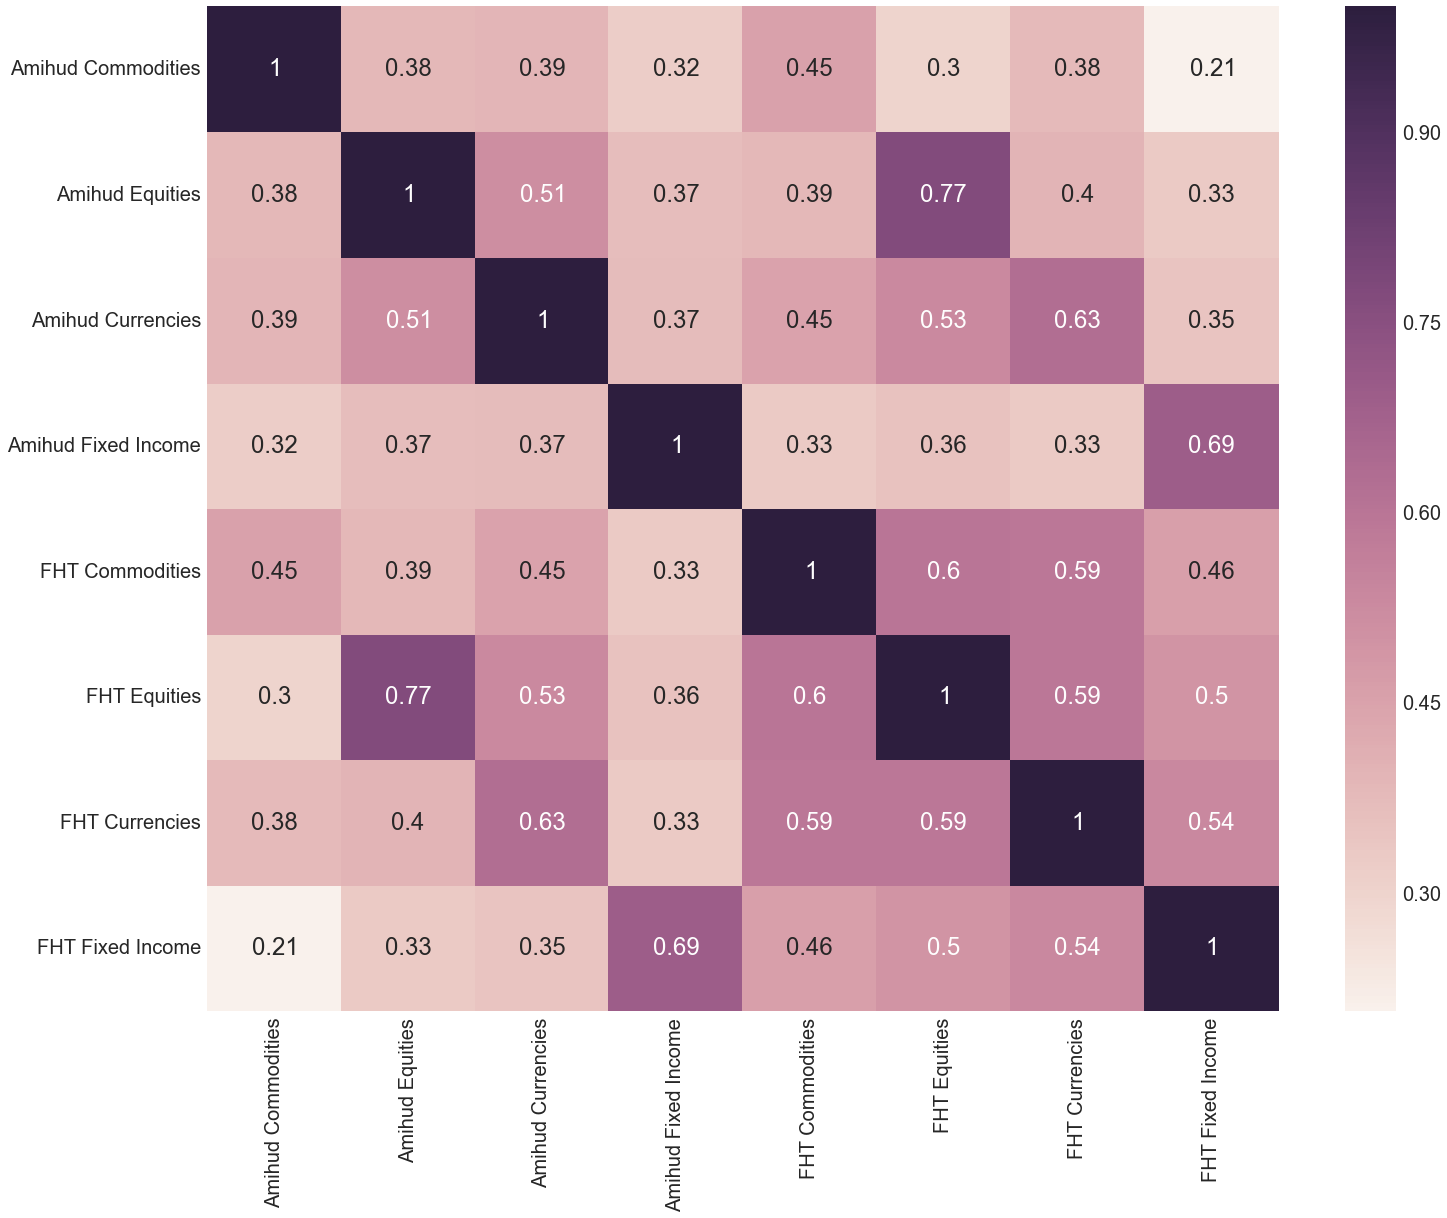

In [25]:
sns.heatmap(resid_df.corr().abs(),annot=True)

In [20]:
print resid_df.corr().abs().round(2).to_latex()

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Amihud Commodities &  Amihud Equities &  Amihud Currencies &  Amihud Fixed Income &  FHT Commodities &  FHT Equities &  FHT Currencies &  FHT Fixed Income \\
\midrule
Amihud Commodities  &                1.00 &             0.38 &               0.39 &                 0.32 &             0.45 &          0.30 &            0.38 &              0.21 \\
Amihud Equities     &                0.38 &             1.00 &               0.51 &                 0.37 &             0.39 &          0.77 &            0.40 &              0.33 \\
Amihud Currencies   &                0.39 &             0.51 &               1.00 &                 0.37 &             0.45 &          0.53 &            0.63 &              0.35 \\
Amihud Fixed Income &                0.32 &             0.37 &               0.37 &                 1.00 &             0.33 &          0.36 &            0.33 &              0.69 \\
FHT Commodities     &                0.45 &             0.39 &     